In [9]:
# Core libraries
import numpy as np
import pandas as pd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Add

In [10]:
import rasterio
from rasterio.enums import Resampling
from rasterio.features import rasterize
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import folium.plugins
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import geopandas as gpd
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input

In [26]:
tif_files_and_Geophys = [
    'Data/Soil_Geochem/Soil_IDW_As/Soil_IDW_As.tif',  #Arsenic
    'Data/Soil_Geochem/Soil_IDW_Au/Soil_IDW_Au.tif',  #Gold
    'Data/Soil_Geochem/Soil_IDW_Hg/Soil_IDW_Hg.tif',  #Mercury
    'Data/Soil_Geochem/Soil_IDW_Sb/Soil_IDW_Sb.tif',  #Antimony
    'Data/Soil_Geochem/Soil_IDW_Te/Soil_IDW_Te.tif',  #Tellurium
    'Data/Geophysical_Anomaly/GeoPhysAnomaly_DONE.tif', #Geophysical Anomaly
    'Data/Fault_data/Structures_Raster.tif'           #Fault data
]

In [27]:
#setting label or target of model
"""with rasterio.open("Data/Gold_Litho_0_4/Gold_litho_zero_to_four.tif") as src:
    gold_labels = src.read(1)
    transform = src.transform
plt.imshow(gold_labels, cmap="hot", interpolation="nearest")
plt.title("Gold Lithology")
plt.axis("off")
plt.show()"""

'with rasterio.open("Data/Gold_Litho_0_4/Gold_litho_zero_to_four.tif") as src:\n    gold_labels = src.read(1)\n    transform = src.transform\nplt.imshow(gold_labels, cmap="hot", interpolation="nearest")\nplt.title("Gold Lithology")\nplt.axis("off")\nplt.show()'

In [28]:
num_rasters = len(tif_files_and_Geophys)
raster_data = []

# Flatten each raster and append to the list
for i in range(num_rasters):
    with rasterio.open(tif_files_and_Geophys[i]) as src:
        data = src.read(1).flatten()
        raster_data.append(data)

#Create a DataFrame from flattened raster data and gold raster data
df = pd.DataFrame(raster_data).T
df['Gold_Litho'] = gold_labels.flatten()


In [29]:
#setting grid
cell_size = 0.005
width = src.width * transform.a
height = src.height * abs(transform.e)
xmin = transform.c
ymax = transform.f
xmax = xmin + width
ymin = ymax - height

#applying grid
x, y = np.meshgrid(np.arange(xmin, xmax, cell_size), np.arange(ymax, ymin, -cell_size))
x = x.flatten()
y = y.flatten()

grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x, y)
).buffer(cell_size / 2, cap_style=3)

#seperating training and testing set based on grid
n_samples = len(grid)

n_train = int(n_samples * (1 - 0.2))
n_test = n_samples - n_train

train_grid = grid.sample(n=n_train, random_state=42)
test_grid = grid.drop(train_grid.index)

train_mask = rasterize(
    shapes=train_grid.geometry,
    out_shape=gold_labels.shape[0:2],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)

test_mask = rasterize(
    shapes=test_grid.geometry,
    out_shape=gold_labels.shape[0:2],
    transform=transform,
    fill=0,
    default_value=1,
    dtype=rasterio.uint8,
)


In [30]:
train_labels = gold_labels.squeeze() * train_mask
test_labels = gold_labels.squeeze() * test_mask

train_features_list = []
test_features_list = []

for tif_file in tif_files_and_Geophys:
    with rasterio.open(tif_file) as src:
        data = src.read(1)

        train_data = data * train_mask
        test_data = data * test_mask

        train_features_list.append(train_data)
        test_features_list.append(test_data)

train_features = np.stack(train_features_list, axis=-1)
test_features = np.stack(test_features_list, axis=-1)

In [31]:
from abc import update_abstractmethods

In [32]:
# Flatten features from (H, W, bands) → (num_pixels, bands)
train_features = train_features.reshape(train_features.shape[0] * train_features.shape[1], train_features.shape[2])
test_features = test_features.reshape(test_features.shape[0] * test_features.shape[1], test_features.shape[2])

# Flatten labels from (H, W) → (num_pixels,)
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()


In [33]:
# Keep only pixels that are not nodata (255)
train_valid_mask = train_labels != 255
test_valid_mask = test_labels != 255

train_features = train_features[train_valid_mask]
train_labels = train_labels[train_valid_mask]

test_features = test_features[test_valid_mask]
test_labels = test_labels[test_valid_mask]


In [34]:
print(np.unique(train_labels))
print(np.unique(test_labels))


[0 1]
[0 1]


In [35]:
print("Train:", np.unique(train_labels, return_counts=True))
print("Test:", np.unique(test_labels, return_counts=True))


Train: (array([0, 1], dtype=uint8), array([94209, 10740]))
Test: (array([0, 1], dtype=uint8), array([102252,   2697]))


In [36]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {int(cls): w for cls, w in zip(np.unique(train_labels), class_weights)}
sample_weights = np.array([class_weights_dict[int(label)] for label in train_labels])


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input

# RNN expects input shape (samples, time_steps, features)
# We treat the 7 features as a sequence of length 7 with 1 feature at each step
train_seq = train_features.reshape(train_features.shape[0], train_features.shape[1], 1)
test_seq = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)

# Build the RNN model
rnn_model = Sequential([
    Input(shape=(train_seq.shape[1], 1)),  # (time_steps=7, features=1)
    GRU(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # binary classification (0 or 1)
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [38]:
rnn_model.fit(train_seq, train_labels,
              epochs=200,
              validation_data=(test_seq, test_labels),
              sample_weight=sample_weights)


Epoch 1/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step - accuracy: 0.7790 - loss: 0.5314 - val_accuracy: 0.9434 - val_loss: 0.2065
Epoch 2/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.8049 - loss: 0.4297 - val_accuracy: 0.9560 - val_loss: 0.1927
Epoch 3/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.8258 - loss: 0.3773 - val_accuracy: 0.9600 - val_loss: 0.1625
Epoch 4/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.8318 - loss: 0.3637 - val_accuracy: 0.9553 - val_loss: 0.1508
Epoch 5/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 28s 8ms/step - accuracy: 0.8436 - loss: 0.3413 - val_accuracy: 0.9639 - val_loss: 0.1793
Epoch 6/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.8452 - loss: 0.3358 - val_accuracy: 0.9634 - val_loss: 0.1486
Epoch 7/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step - accuracy: 0.8529 - loss: 0.3282 - val_accuracy: 0.9648 - val_loss: 0.1980
Epoch 8/200
3280/3280 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - accuracy: 0.8571 -

3280/3280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


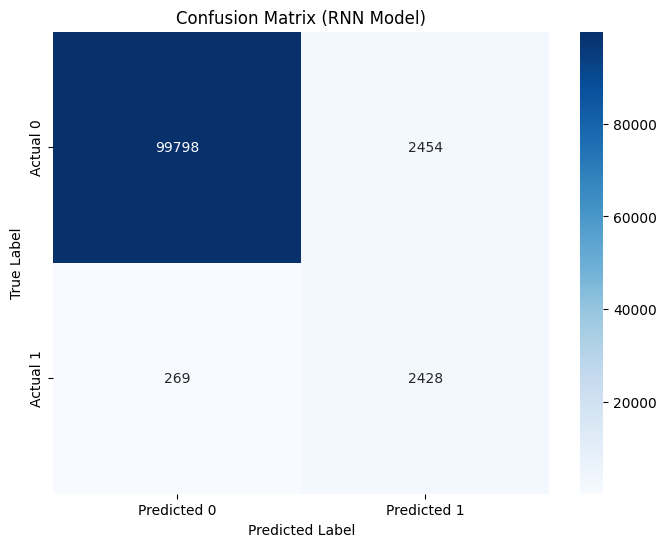

Accuracy : 0.9741
Precision: 0.4973
Recall   : 0.9003
F1 Score : 0.6407


In [53]:
# Predict using test sequence (reshaped earlier)
predictions = rnn_model.predict(test_seq)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=-1).flatten()
true_labels = test_labels.flatten()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (RNN Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')
plt.show()

# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Display metrics
print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))


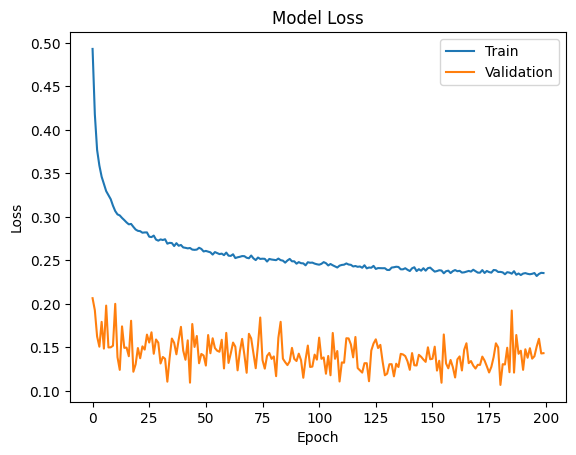

In [58]:
plt.plot(rnn_model.history.history['loss'])
plt.plot(rnn_model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('rnn_model_loss.png')
plt.show()

In [59]:
#generating data from testing data
test_seq = test_features.reshape(test_features.shape[0], test_features.shape[1], 1)
predictions = rnn_model.predict(test_seq)


3280/3280 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


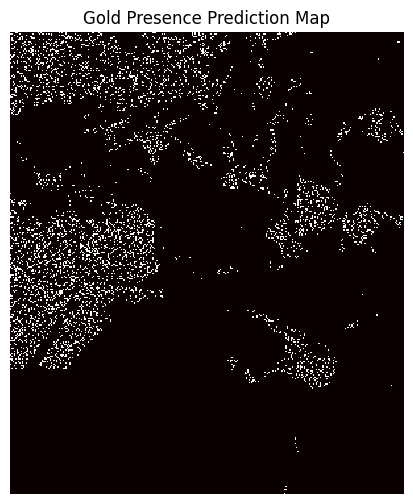

In [60]:
plt.figure(figsize=(10, 6))
#class with the highest probability
predicted_class = np.argmax(predictions, axis=-1)
predicted_class = predicted_class.reshape(gold_labels.shape[0], gold_labels.shape[1])
plt.imshow(predicted_class, cmap="hot", interpolation="nearest")
plt.title("Gold Presence Prediction Map")
plt.axis("off")
plt.savefig('rnn_gold_presence_heatmap.png')
plt.show()

3280/3280 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


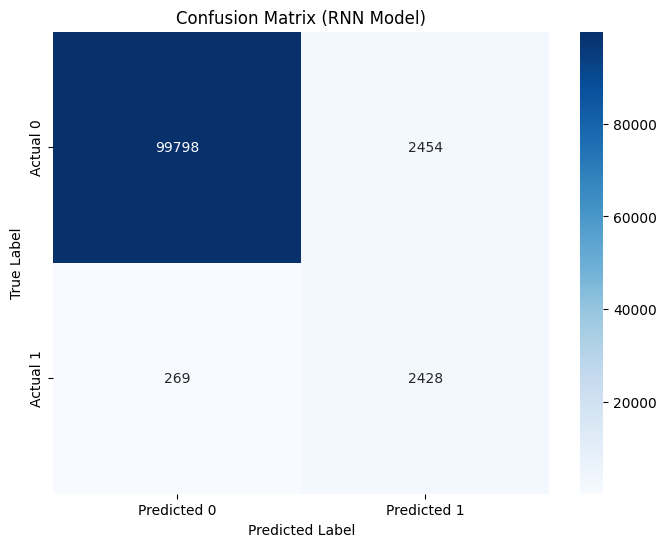

Accuracy : 0.9741
Precision: 0.4973
Recall   : 0.9003
F1 Score : 0.6407


In [61]:
# Predict using test sequence (reshaped earlier)
predictions = rnn_model.predict(test_seq)

# Get predicted labels and probabilities
predicted_labels = np.argmax(predictions, axis=-1).flatten()
predicted_probs = predictions[:, 1]  # Probability for class 1 (mine)
true_labels = test_labels.flatten()

# Confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (RNN Model)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('rnn_confusion_matrix.png')
plt.show()

# Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Display metrics
print("Accuracy :", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Recall   :", round(recall, 4))
print("F1 Score :", round(f1, 4))

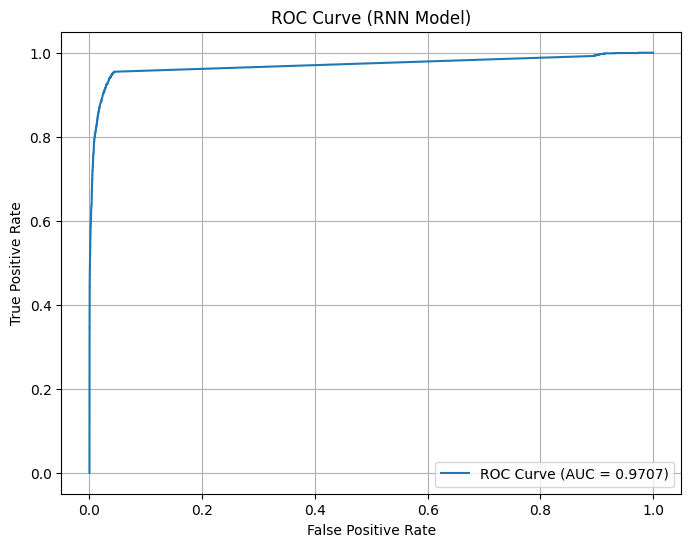

In [66]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (RNN Model)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('rnn_roc_curve.png')
plt.show()



In [67]:
#saving heatmap as raster for arc visualization
with rasterio.open(tif_files_and_Geophys[0]) as src:
    profile = src.profile

profile.update({
    'dtype': rasterio.float32,
    'count': predictions.shape[-1]
})


with rasterio.open("rnn_gold_presence_soil.tif", "w", **profile) as dst:
    for i in range(predictions.shape[-1]):
        dst.write(predictions[:, i].astype(rasterio.float32).reshape(gold_labels.shape[0], gold_labels.shape[1]), i + 1)

print("Heatmap exported as rnn_gold_presence_heatmap.tif")

Heatmap exported as rnn_gold_presence_heatmap.tif
